# Define patient and hospital object and functions

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

class Patient:
    def __init__(self, template):
        self.mortality_score = np.clip(template['mortality_score'] + np.random.normal(0, template.get('mortality_std', 0)), 0.05, 0.95) # if it reach 1, patient will die in the next day
        self.category = np.random.choice(template['category'])
        self.waiting_day = 0 # tracking of waiting day
        self.admission_priority = 0 # tracking the admission priority under different strategy
        self.discharge_score = 0 #if it reach 1, patient will be discharged in the next day
        self.hospitalization_day = 0 # tracking of waiting day

class Hospital:
    def __init__(self, bed_dict, bed_count=30, team_count=3):
        self.bed_dict = bed_dict # key is 0-29 (bed number), value is a tuple (medical team, patient)
        self.bed_count = bed_count # max length of bed_list
        self.team_count = team_count
        self.team_patient = np.zeros(team_count)
        self.team_category = np.zeros((team_count, 5)) # array storing number of day since the last encounter for a specific category (column) of patient for each team (row)
        self.available_bed = list(range(bed_count))

# Each day of waiting
def generate_patients(templates, weights, num_patients):
    patients = []
    for _ in range(num_patients):
        random_template = random.choices(templates, weights, k=1)[0]
        patient = Patient(random_template)
        patients.append(patient)
    return patients

def waiting_patients_day(admission_waiting_list, waiting_to_dead_list, mortality_inflation, templates, weights, num_patients):
    '''
    mortality_inflation: rate of
    templates: list of patient template for new patient generation
    weights: possibility of each patient template being selected
    num_patients: number of new patient added per day
    '''
    # modify the old patients
    admission_waiting_list_copy = admission_waiting_list.copy()
    for patient in admission_waiting_list_copy:
        if patient.mortality_score >= 1:
            waiting_to_dead_list.append(patient)
            admission_waiting_list.remove(patient)
            continue
        patient.waiting_day += 1
        patient.mortality_score = np.clip(np.random.normal(patient.mortality_score * mortality_inflation, 0.05), 0, 1)
    # add new patients
    new_patients = generate_patients(templates, weights, num_patients)
    admission_waiting_list.extend(new_patients)
    return admission_waiting_list, waiting_to_dead_list

# Calling admission
def calling_admission(hospital, admission_waiting_list, emergent_mortality_threshold=0.9, preference_weight=[1,1,1]):
    '''
    preference_weight: relative weight of mortality, patient waiting time, educational value (it will be normalize spontaneously)
    '''
    ##### queue the admission waiting list
    # sort the emergent patient with high mortality to the front
    if len(admission_waiting_list) == 0:
        return hospital, admission_waiting_list

    admission_waiting_list.sort(key=lambda patient: patient.mortality_score, reverse=True)
    first_nonemergent_patient = next((i for i, patient in enumerate(admission_waiting_list) if patient.mortality_score <= emergent_mortality_threshold), len(admission_waiting_list))

    # Normalize preference_weight
    preference_weight = np.array(preference_weight)/sum(preference_weight)
    max_waiting_day = max(patient.waiting_day for patient in admission_waiting_list[first_nonemergent_patient:])

    # Calculate the education preference
    team_category_array = hospital.team_category.copy()
    available_team = []
    # If a medical team is full, we don't consider their preference
    for team in range(hospital.team_count):
        if hospital.team_patient[team]>=10:
            team_category_array[team] = np.zeros(5)
        else:
            available_team.append(team) # the team that can handel newly admitted patients

    if np.any(team_category_array != 0):
        team_category_array = np.sum(team_category_array, axis=0)/np.sum(team_category_array) #column sum and noramlize for each patient category
    else:
        team_category_array = np.zeros(5)

    # Sort nonemergent patient based on preference
    for patient in admission_waiting_list[first_nonemergent_patient:]:
        preference_data = np.array([patient.mortality_score, patient.waiting_day/(max_waiting_day+1), team_category_array[patient.category]])
        patient.admission_priority = np.dot(preference_weight, preference_data)

    admission_waiting_list[first_nonemergent_patient:].sort(key=lambda patient: patient.admission_priority, reverse=True)

    ##### calling patient for empty bed
    hospital_available_bed_copy = hospital.available_bed.copy()
    for bed_no in hospital_available_bed_copy:
        hospital.available_bed.remove(bed_no)
        patient = admission_waiting_list.pop(0)
        selected_team = available_team[np.argmax(hospital.team_category[available_team,patient.category])]
        hospital.bed_dict[bed_no] = (selected_team, patient)
        hospital.team_patient[selected_team] +=1 #The team had one more patient
        if hospital.team_patient[selected_team] >=10:
            available_team.remove(selected_team) # The team is no more available
        if len(admission_waiting_list) == 0:
            break
    return hospital, admission_waiting_list

# Each day admitted
def sigmoid(x):
    return - 0.5 / (1 + np.exp((-x+0.5)*10)) + 0.25

def hospital_day(hospital, mortality_reduction):
    # modify team_category in hospital
    hospital.team_category = hospital.team_category + 1

    # modify mortality_score, discharge_score, hospitalization_day in paitents
    hospital_bed_dict_copy = hospital.bed_dict.copy()
    for bed_no, (team_no, patient) in hospital_bed_dict_copy.items():

        unfamiliarity = hospital.team_category[team_no , patient.category] + 1 # how long the team had no experience taking care of such patient

        patient.mortality_score = np.clip(np.random.normal(patient.mortality_score * mortality_reduction, 0.1 * unfamiliarity), 0, 1)
        patient.discharge_score = np.clip((patient.discharge_score + sigmoid(patient.mortality_score) - unfamiliarity / 10), 0, 1)
        patient.hospitalization_day += 1

        hospital.team_category[team_no, patient.category] = 0 # become familier after caring for patient
    return hospital

# Hospital discharge
def hospital_discharge(hospital, discharge_alive_list, discharge_dead_list):
    hospital_bed_dict_copy = hospital.bed_dict.copy()
    for bed_no, (team_no, patient) in hospital_bed_dict_copy.items():
        if patient.mortality_score >= 1:
            dead_patient = hospital.bed_dict.pop(bed_no)
            discharge_dead_list.append(dead_patient)
            hospital.team_patient[team_no] -=1
            hospital.available_bed.append(bed_no)
        elif patient.discharge_score >= 1:
            discharged_patient = hospital.bed_dict.pop(bed_no)
            discharge_alive_list.append(discharged_patient)
            hospital.team_patient[team_no] -=1
            hospital.available_bed.append(bed_no)
    return hospital, discharge_alive_list, discharge_dead_list

# Run simulation

In [3]:
import copy

#Template for patient generation
template_disease = {
    'mortality_score': 0.25,
    'mortality_std': 0.125,
    'category': [0]
}

template_survey = {
    'mortality_score': 0.1,
    'mortality_std': 0.05,
    'category': [1, 2, 3, 4]
}

# Parameter in patient generation and waiting admission
templates = [template_disease, template_survey]
weights=[0.8, 0.2] # weight of drawing from each template
num_patients = 5 # number of patient generated per day
mortality_inflation = 1.1 # expected mortality change per day

# Parameter for calling admission
preference_weight = [1,1,1] # relative weight of mortality, patient waiting time, educational value (it will be normalize spontaneously)
emergent_mortality_threshold = 0.9 # If mortality is higher than this, the patient had the highest priority of admission

# Parameter for hospitalized patient
mortality_reduction = 0.8 # expected mortality change per day

##### Parameter use to test multiple dead patient
# template_disease = {
#     'mortality_score': 0.8,
#     'mortality_std': 0.25,
#     'category': [0]
# }

# template_survey = {
#     'mortality_score': 0.5,
#     'mortality_std': 0.5,
#     'category': [1, 2, 3, 4]
# }
# emergent_mortality_threshold = 1.2

# Initialization
days = 50

discharge_alive_list = []
discharge_dead_list = []
waiting_to_dead_list = []
frames = []
admission_waiting_list = generate_patients(templates, weights, num_patients) # some patient generated during initialization

hospital = Hospital(bed_dict={}, bed_count=30, team_count=3)

for day in range(days):
    # Discharge
    hospital, discharge_alive_list, discharge_dead_list = hospital_discharge(hospital, discharge_alive_list, discharge_dead_list)
    # frames.append((day, copy.deepcopy(admission_waiting_list), copy.deepcopy(hospital.bed_dict), copy.deepcopy(waiting_to_dead_list), copy.deepcopy(discharge_alive_list), copy.deepcopy(discharge_dead_list)))

    # Calling admission
    hospital, admission_waiting_list = calling_admission(hospital, admission_waiting_list, emergent_mortality_threshold, preference_weight)
    # frames.append((day, copy.deepcopy(admission_waiting_list), copy.deepcopy(hospital.bed_dict), copy.deepcopy(waiting_to_dead_list), copy.deepcopy(discharge_alive_list), copy.deepcopy(discharge_dead_list)))

    # Passing of the day in waiting list
    admission_waiting_list, waiting_to_dead_list = waiting_patients_day(admission_waiting_list, waiting_to_dead_list, mortality_inflation, templates, weights, num_patients)
    # frames.append((day, copy.deepcopy(admission_waiting_list), copy.deepcopy(hospital.bed_dict), copy.deepcopy(waiting_to_dead_list), copy.deepcopy(discharge_alive_list), copy.deepcopy(discharge_dead_list)))

    # Passing of the day in hospital
    hospital = hospital_day(hospital, mortality_reduction)
    frames.append((day, copy.deepcopy(admission_waiting_list), copy.deepcopy(hospital.bed_dict), copy.deepcopy(waiting_to_dead_list), copy.deepcopy(discharge_alive_list), copy.deepcopy(discharge_dead_list)))

# Animation

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
from matplotlib import cm
from IPython.display import HTML

fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Calculate category
categories = set()
for template in templates:
    categories.update(template['category'])

# define mark for category and teams
category_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen', 3: 'lightyellow', 4: 'lightgrey'}
category_markers = {0: 'P', 1: 's', 2: 'D', 3: '^', 4: 'o'}
team_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Initialize the data for figure
admission_waiting_list_scatter = {}
waiting_to_dead_list_scatter = {}
discharge_alive_list_scatter = {}
discharge_dead_list_scatter = {}
for category in categories:
    marker = category_markers.get(category, 'v')
    admission_waiting_list_scatter[category] = axs[0, 0].scatter([], [], marker=marker, label=f'Category {category}', edgecolor='black')
    waiting_to_dead_list_scatter[category] = axs[1, 1].scatter([], [], marker=marker, label=f'Category {category}', edgecolor='black', alpha = 0.7)
    discharge_alive_list_scatter[category] = axs[2, 0].scatter([], [], marker=marker, label=f'Category {category}', edgecolor='black', alpha=0.7)
    discharge_dead_list_scatter[category] = axs[2, 1].scatter([], [], marker=marker, label=f'Category {category}', edgecolor='black', alpha=0.7)

# admission_waiting_list
axs[0, 0].set_title('Admission Waiting List')
# underground with color for disease category
for i, category in enumerate(categories):
    color = category_colors.get(category, 'white')
    axs[0, 0].add_patch(plt.Rectangle((i, 0), 1, days, color=color, alpha=0.5))
    axs[0, 0].text(i + 0.5, -0.5, str(category), ha='center', va='center')

axs[0, 0].set_xlim(0, len(categories))
axs[0, 0].set_ylim(0, days)
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks(list(range(days)))
axs[0, 0].set_yticklabels(list(range(days)), fontsize=6)
axs[0, 0].set_ylabel("Waiting Days")
axs[0, 0].set_xlabel("Patient category")
axs[0, 0].xaxis.set_label_coords(0.5, -0.05)

# hospital.bed_dict
axs[1, 0].set_title('Hospital Bed Dict')
rows = 4
cols = hospital.bed_count // rows + (hospital.bed_count % rows > 0)
for i in range(hospital.bed_count):
    row = i % rows
    col = i // rows
    axs[1, 0].add_patch(plt.Rectangle((col, row), 1, 1, color='lightgrey', alpha=0.5))
    axs[1, 0].text(col + 0.1, row + 0.1, str(i), ha='center', va='center')

axs[1, 0].set_xlim(0, cols)
axs[1, 0].set_ylim(0, rows)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
hospital_bed_dict_plot, = axs[1, 0].plot([], [], 'go')

# waiting_to_dead_list
axs[1, 1].set_title('Waiting to Dead List')
axs[1, 1].set_xlim(0, days)
axs[1, 1].set_ylim(0, days)
axs[1, 1].set_xticks(list(range(days)))
axs[1, 1].set_yticks(list(range(days)))
axs[1, 1].set_xticklabels(list(range(days)), fontsize=6)
axs[1, 1].set_yticklabels(list(range(days)), fontsize=6)
axs[1, 1].set_xlabel("Waiting Days")
axs[1, 1].set_ylabel("Number")

# discharge_alive_list
axs[2, 0].set_title('Discharge Alive List')
axs[2, 0].set_xlim(0, days)
axs[2, 0].set_ylim(0, days)
axs[2, 0].set_xticks(list(range(days)))
axs[2, 0].set_yticks(list(range(days)))
axs[2, 0].set_xticklabels(list(range(days)), fontsize=6)
axs[2, 0].set_yticklabels(list(range(days)), fontsize=6)
axs[2, 0].set_xlabel("Hospitalized Days")
axs[2, 0].set_ylabel("Number")
discharge_alive_list_plot, = axs[2, 0].plot([], [], 'co')

# discharge_dead_list
axs[2, 1].set_title('Discharge Dead List')
axs[2, 1].set_xlim(0, days)
axs[2, 1].set_ylim(0, days)
axs[2, 1].set_xticks(list(range(days)))
axs[2, 1].set_yticks(list(range(days)))
axs[2, 1].set_xticklabels(list(range(days)), fontsize=6)
axs[2, 1].set_yticklabels(list(range(days)), fontsize=6)
axs[2, 1].set_xlabel("Hospitalized Days")
axs[2, 1].set_ylabel("Number")
discharge_dead_list_plot, = axs[2, 1].plot([], [], 'mo')

# Hide subplot not used
axs[0, 1].axis('off')
plt.tight_layout()

def init():
    for scatter in admission_waiting_list_scatter.values():
        scatter.set_offsets(np.empty((0, 2)))
        scatter.set_facecolor([])
    for scatter in waiting_to_dead_list_scatter.values():
        scatter.set_offsets(np.empty((0, 2)))
        scatter.set_facecolor([])
    for scatter in discharge_alive_list_scatter.values():
        scatter.set_offsets(np.empty((0, 2)))
        scatter.set_facecolor([])
    for scatter in discharge_dead_list_scatter.values():
        scatter.set_offsets(np.empty((0, 2)))
        scatter.set_facecolor([])
    hospital_bed_dict_plot.set_data([], [])
    return list(admission_waiting_list_scatter.values()) + list(waiting_to_dead_list_scatter.values()) + list(discharge_alive_list_scatter.values()) + list(discharge_dead_list_scatter.values()) + [hospital_bed_dict_plot]


def update(frame):
    day, admission_waiting_list, hospital_bed_dict, waiting_to_dead_list, discharge_alive_list, discharge_dead_list = frames[frame]

    # Update titles
    axs[0, 0].set_title(f'Admission Waiting List - Day {day}')
    axs[1, 0].set_title(f'Hospital Bed Dict - Day {day}')
    axs[1, 1].set_title(f'Waiting to Dead List - Day {day}')
    axs[2, 0].set_title(f'Discharge Alive List - Day {day}')
    axs[2, 1].set_title(f'Discharge Dead List - Day {day}')

    # Update admission_waiting_list data
    for category in categories:
        x_data = []
        y_data = []
        colors = []
        waiting_day_matrix = np.zeros((days+1, len(categories)))
        for patient in admission_waiting_list:
            if patient.category == category:
                x = patient.category + waiting_day_matrix[patient.waiting_day, patient.category] / num_patients + 0.1
                waiting_day_matrix[patient.waiting_day, patient.category] += 1
                y = patient.waiting_day
                x_data.append(x)
                y_data.append(y)
                colors.append(cm.Reds(patient.mortality_score))
        scatter = admission_waiting_list_scatter[category]
        scatter.set_offsets(np.c_[x_data, y_data])
        scatter.set_facecolor(colors)

    # Update waiting_to_dead_list data
    for category in categories:
        x_data = []
        y_data = []
        colors = []
        waiting_day_matrix = np.zeros((days+1, len(categories)))
        for patient in waiting_to_dead_list:
            if patient.category == category:
                x = patient.waiting_day + patient.category / num_patients / 1.5
                waiting_day_matrix[patient.waiting_day, patient.category] += 1
                y = waiting_day_matrix[patient.waiting_day, patient.category]
                x_data.append(x)
                y_data.append(y)
                colors.append(category_colors[category])
        scatter = waiting_to_dead_list_scatter[category]
        scatter.set_offsets(np.c_[x_data, y_data])
        scatter.set_facecolor(colors)

    # Update discharge_alive_list data
    for category in categories:
        x_data = []
        y_data = []
        face_colors = []
        edge_colors = []
        waiting_day_matrix = np.zeros((days+1, len(categories)))
        for team, patient in discharge_alive_list:
            if patient.category == category:
                x = patient.hospitalization_day + patient.category / num_patients / 1.5
                waiting_day_matrix[patient.hospitalization_day, patient.category] += 1
                y = waiting_day_matrix[patient.hospitalization_day, patient.category]
                x_data.append(x)
                y_data.append(y)
                face_colors.append(category_colors[category])
                edge_colors.append(team_colors.get(team, 'black'))

        scatter = discharge_alive_list_scatter[category]
        scatter.set_offsets(np.c_[x_data, y_data])
        scatter.set_facecolor(face_colors)
        scatter.set_edgecolor(edge_colors)

    # Update discharge_dead_list data
    for category in categories:
        x_data = []
        y_data = []
        face_colors = []
        edge_colors = []
        waiting_day_matrix = np.zeros((days+1, len(categories)))
        for team, patient in discharge_dead_list:
            if patient.category == category:
                x = patient.hospitalization_day + patient.category / num_patients / 1.5
                waiting_day_matrix[patient.hospitalization_day, patient.category] += 1
                y = waiting_day_matrix[patient.hospitalization_day, patient.category]
                x_data.append(x)
                y_data.append(y)
                face_colors.append(category_colors[category])
                edge_colors.append(team_colors.get(team, 'black'))

        scatter = discharge_dead_list_scatter[category]
        scatter.set_offsets(np.c_[x_data, y_data])
        scatter.set_facecolor(face_colors)
        scatter.set_edgecolor(edge_colors)

    # Update hospital_bed_dict data
    x_data = []
    y_data = []
    markers = []
    face_colors = []
    edge_colors = []

    rows = 4
    for bed, (team, patient) in hospital_bed_dict.items():
        row = bed % rows
        col = bed // rows
        x_data.append(col + 0.5)
        y_data.append(row + 0.5)

        marker = category_markers.get(patient.category, 'o')
        markers.append(marker)
        face_colors.append(cm.Blues(patient.discharge_score))
        edge_colors.append(team_colors.get(team, 'black'))

    for artist in axs[1, 0].collections:
        artist.remove()

    bed_scatters = []
    for x, y, marker, face_color, edge_color in zip(x_data, y_data, markers, face_colors, edge_colors):
        scatter = axs[1, 0].scatter(
            x, y,
            marker=marker,
            c=[face_color],
            edgecolors=edge_color,
            s=200,
            linewidths=1.5
        )
        bed_scatters.append(scatter)

    return (list(admission_waiting_list_scatter.values()) +
            list(waiting_to_dead_list_scatter.values()) +
            list(discharge_alive_list_scatter.values()) +
            list(discharge_dead_list_scatter.values()) +
            bed_scatters)

ani = animation.FuncAnimation(fig, update, init_func=init, frames=len(frames), interval=500, blit=True)
HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

# Static final result

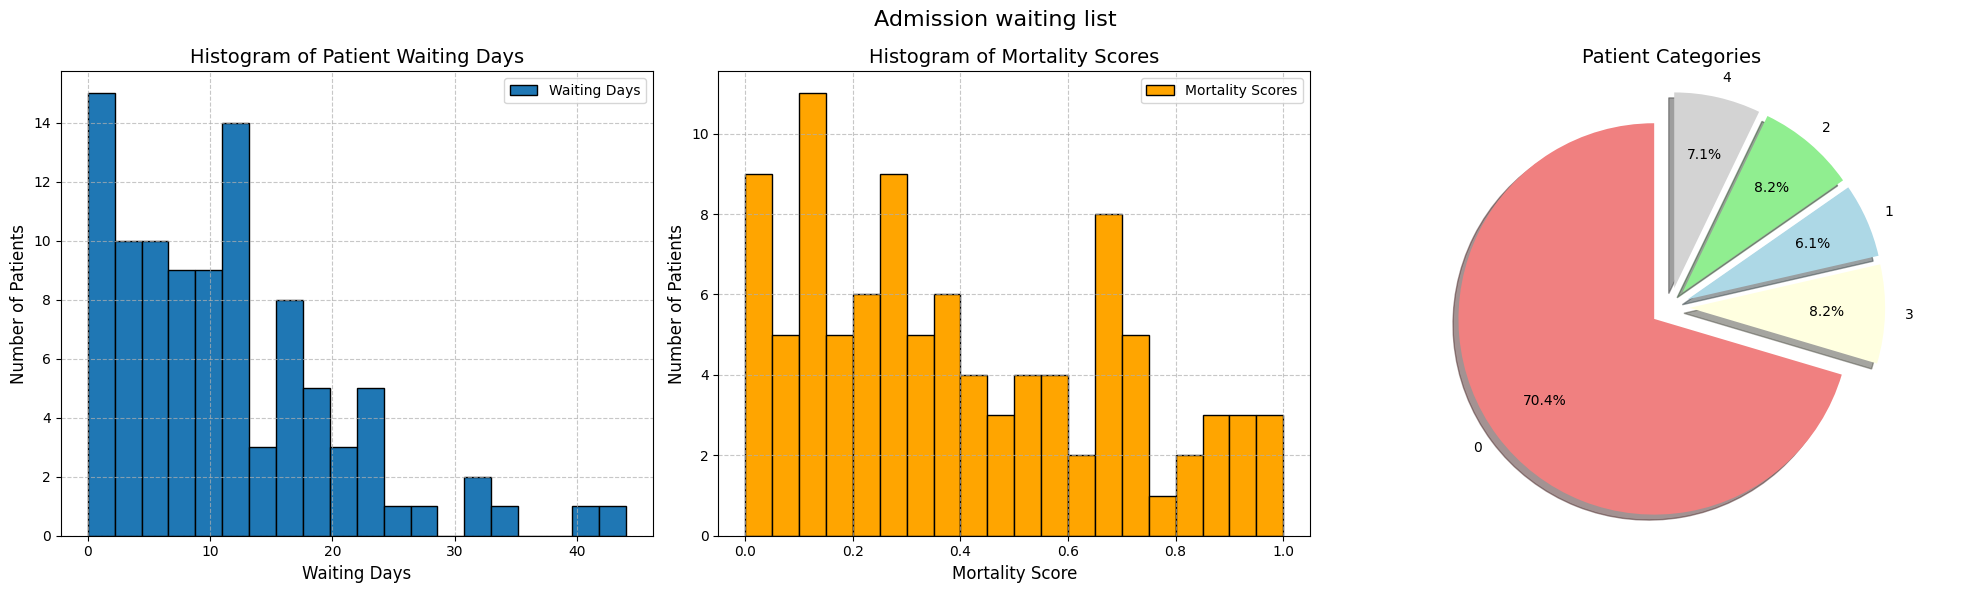

In [18]:
import matplotlib.pyplot as plt

waiting_days = [patient.waiting_day for patient in admission_waiting_list]
mortality_scores = [patient.mortality_score for patient in admission_waiting_list]
patient_categories = [patient.category for patient in admission_waiting_list]

category_counts = {}
for category in patient_categories:
    category_counts[category] = category_counts.get(category, 0) + 1

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].hist(waiting_days, bins=20, edgecolor='black', label='Waiting Days')
axes[0].set_xlabel('Waiting Days', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_title('Histogram of Patient Waiting Days', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Histogram of Mortality Scores
axes[1].hist(mortality_scores, bins=20, edgecolor='black', color='orange', label='Mortality Scores')
axes[1].set_xlabel('Mortality Score', fontsize=12)
axes[1].set_ylabel('Number of Patients', fontsize=12)
axes[1].set_title('Histogram of Mortality Scores', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

# Pie chart of Patient Categories
labels = list(category_counts.keys())
sizes = list(category_counts.values())
explode = [0.1] * len(labels)
category_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen', 3: 'lightyellow', 4: 'lightgrey'}
colors = [category_colors[label] for label in labels]
axes[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, pctdistance=0.7)
axes[2].axis('equal')
axes[2].set_title('Patient Categories', fontsize=14)

fig.suptitle('Admission waiting list', fontsize=16)
plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

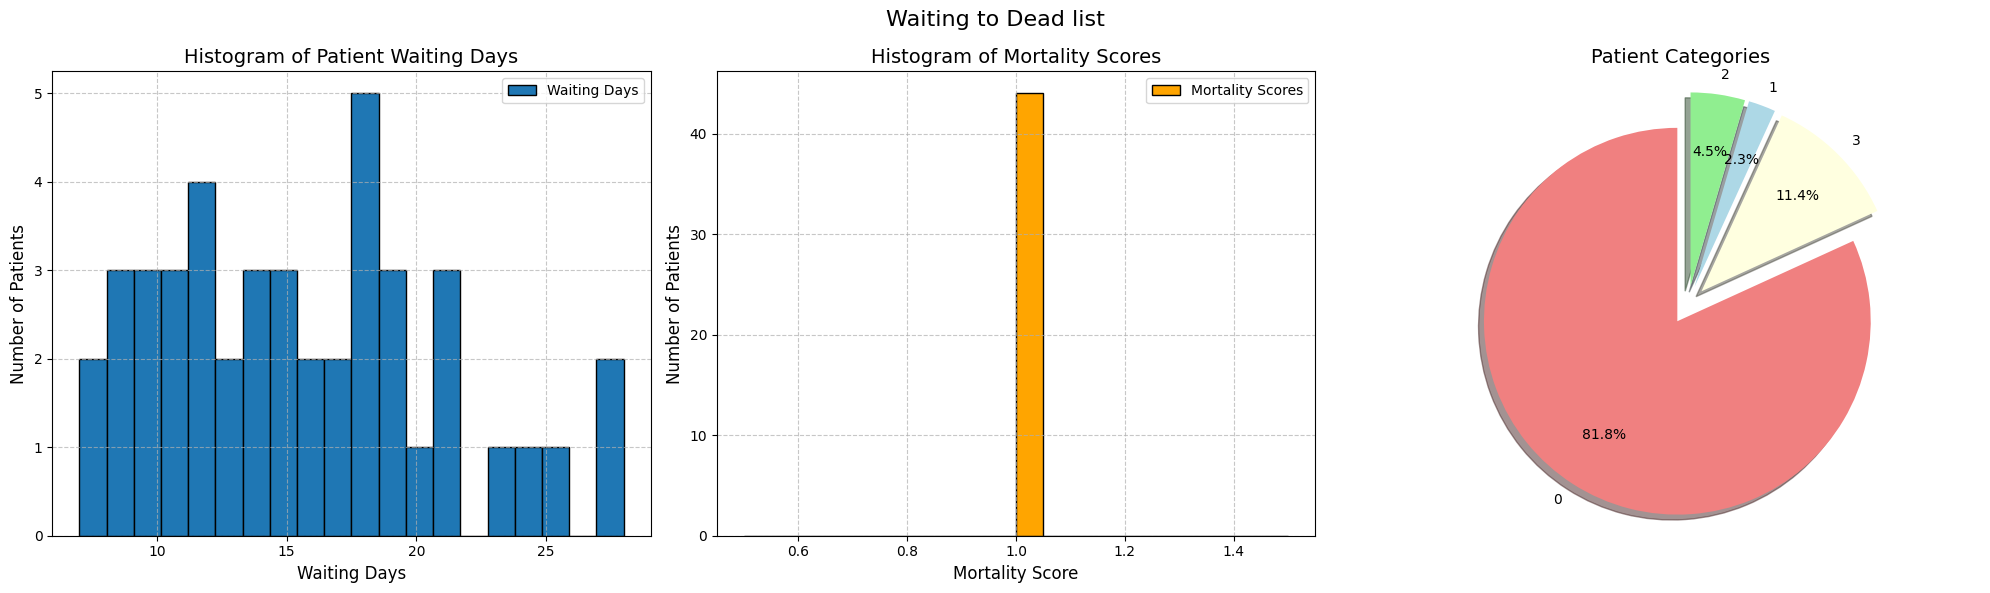

In [19]:
import matplotlib.pyplot as plt

waiting_days = [patient.waiting_day for patient in waiting_to_dead_list]
mortality_scores = [patient.mortality_score for patient in waiting_to_dead_list]
patient_categories = [patient.category for patient in waiting_to_dead_list]

category_counts = {}
for category in patient_categories:
    category_counts[category] = category_counts.get(category, 0) + 1

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].hist(waiting_days, bins=20, edgecolor='black', label='Waiting Days')
axes[0].set_xlabel('Waiting Days', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_title('Histogram of Patient Waiting Days', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Histogram of Mortality Scores
axes[1].hist(mortality_scores, bins=20, edgecolor='black', color='orange', label='Mortality Scores')
axes[1].set_xlabel('Mortality Score', fontsize=12)
axes[1].set_ylabel('Number of Patients', fontsize=12)
axes[1].set_title('Histogram of Mortality Scores', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

# Pie chart of Patient Categories
labels = list(category_counts.keys())
sizes = list(category_counts.values())
explode = [0.1] * len(labels)
category_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen', 3: 'lightyellow', 4: 'lightgrey'}
colors = [category_colors[label] for label in labels]
axes[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, pctdistance=0.7)
axes[2].axis('equal')
axes[2].set_title('Patient Categories', fontsize=14)

fig.suptitle('Waiting to Dead list', fontsize=16)
plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

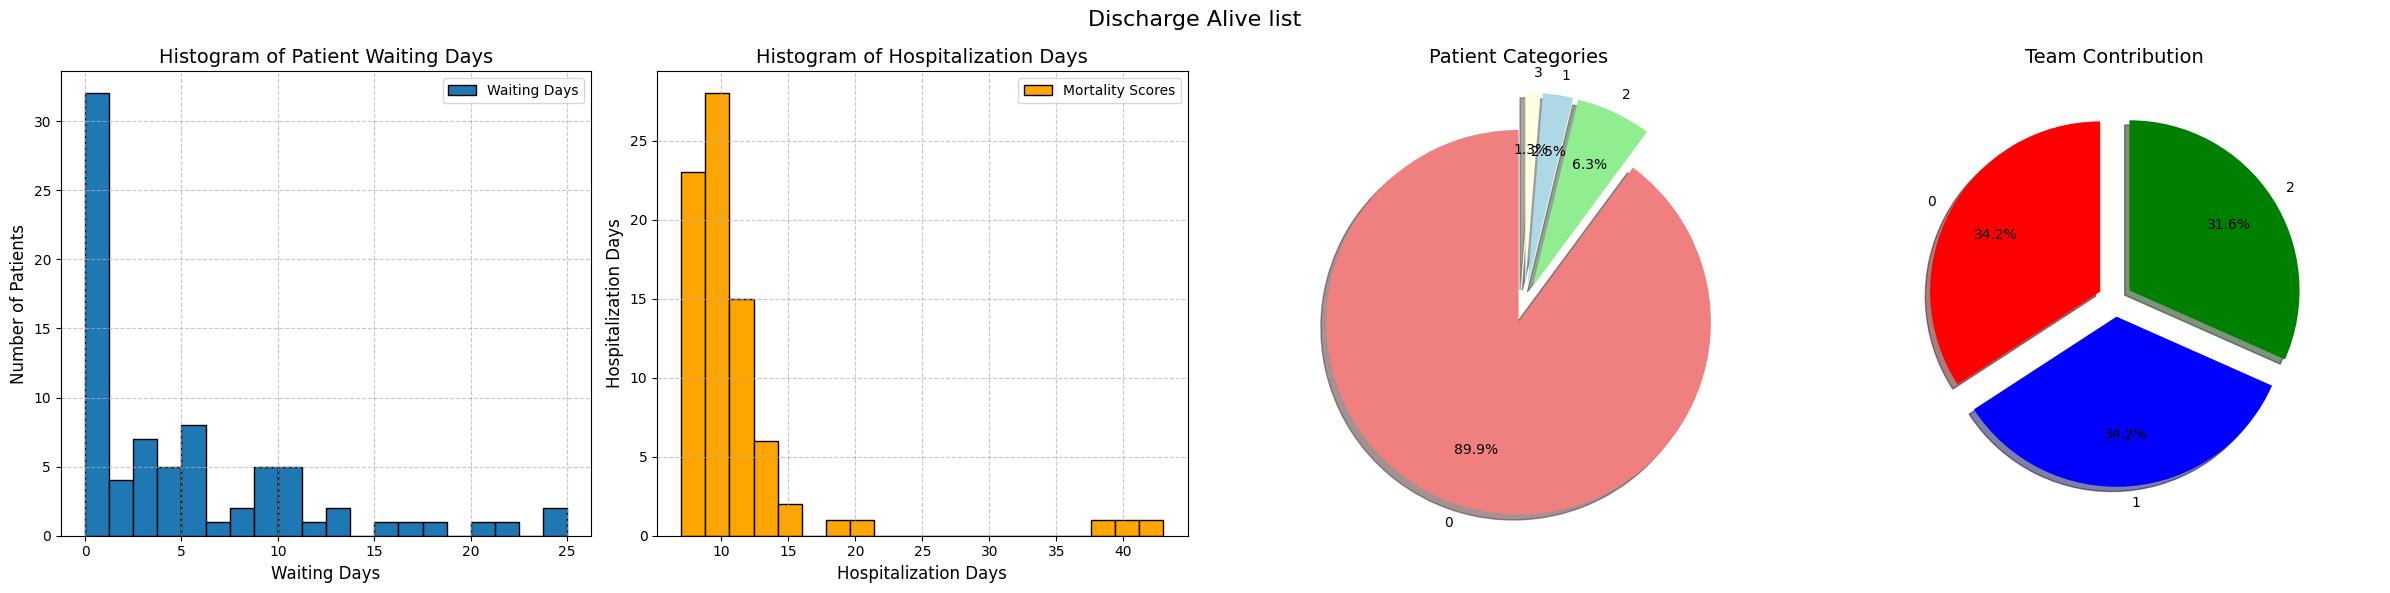

In [20]:
import matplotlib.pyplot as plt

waiting_days = [patient.waiting_day for team, patient in discharge_alive_list]
hospitalization_days = [patient.hospitalization_day for team, patient in discharge_alive_list]
patient_categories = [patient.category for team, patient in discharge_alive_list]
teams = [team for team, patient in discharge_alive_list]

category_counts = {}
for category in patient_categories:
    category_counts[category] = category_counts.get(category, 0) + 1

team_counts = {}
for team in teams:
    team_counts[team] = team_counts.get(team, 0) + 1

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].hist(waiting_days, bins=20, edgecolor='black', label='Waiting Days')
axes[0].set_xlabel('Waiting Days', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_title('Histogram of Patient Waiting Days', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Histogram of Mortality Scores
axes[1].hist(hospitalization_days, bins=20, edgecolor='black', color='orange', label='Mortality Scores')
axes[1].set_xlabel('Hospitalization Days', fontsize=12)
axes[1].set_ylabel('Hospitalization Days', fontsize=12)
axes[1].set_title('Histogram of Hospitalization Days', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

# Pie chart of Patient Categories
labels = list(category_counts.keys())
sizes = list(category_counts.values())
explode = [0.1] * len(labels)
category_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen', 3: 'lightyellow', 4: 'lightgrey'}
colors = [category_colors[label] for label in labels]
axes[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, pctdistance=0.7)
axes[2].axis('equal')
axes[2].set_title('Patient Categories', fontsize=14)

# Pie chart of Patient Categories
labels = list(team_counts.keys())
sizes = list(team_counts.values())
explode = [0.1] * len(labels)
team_colors = {0: 'red', 1: 'blue', 2: 'green'}
colors = [team_colors[label] for label in labels]
axes[3].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, pctdistance=0.7)
axes[3].axis('equal')
axes[3].set_title('Team Contribution', fontsize=14)

fig.suptitle('Discharge Alive list', fontsize=16)
plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

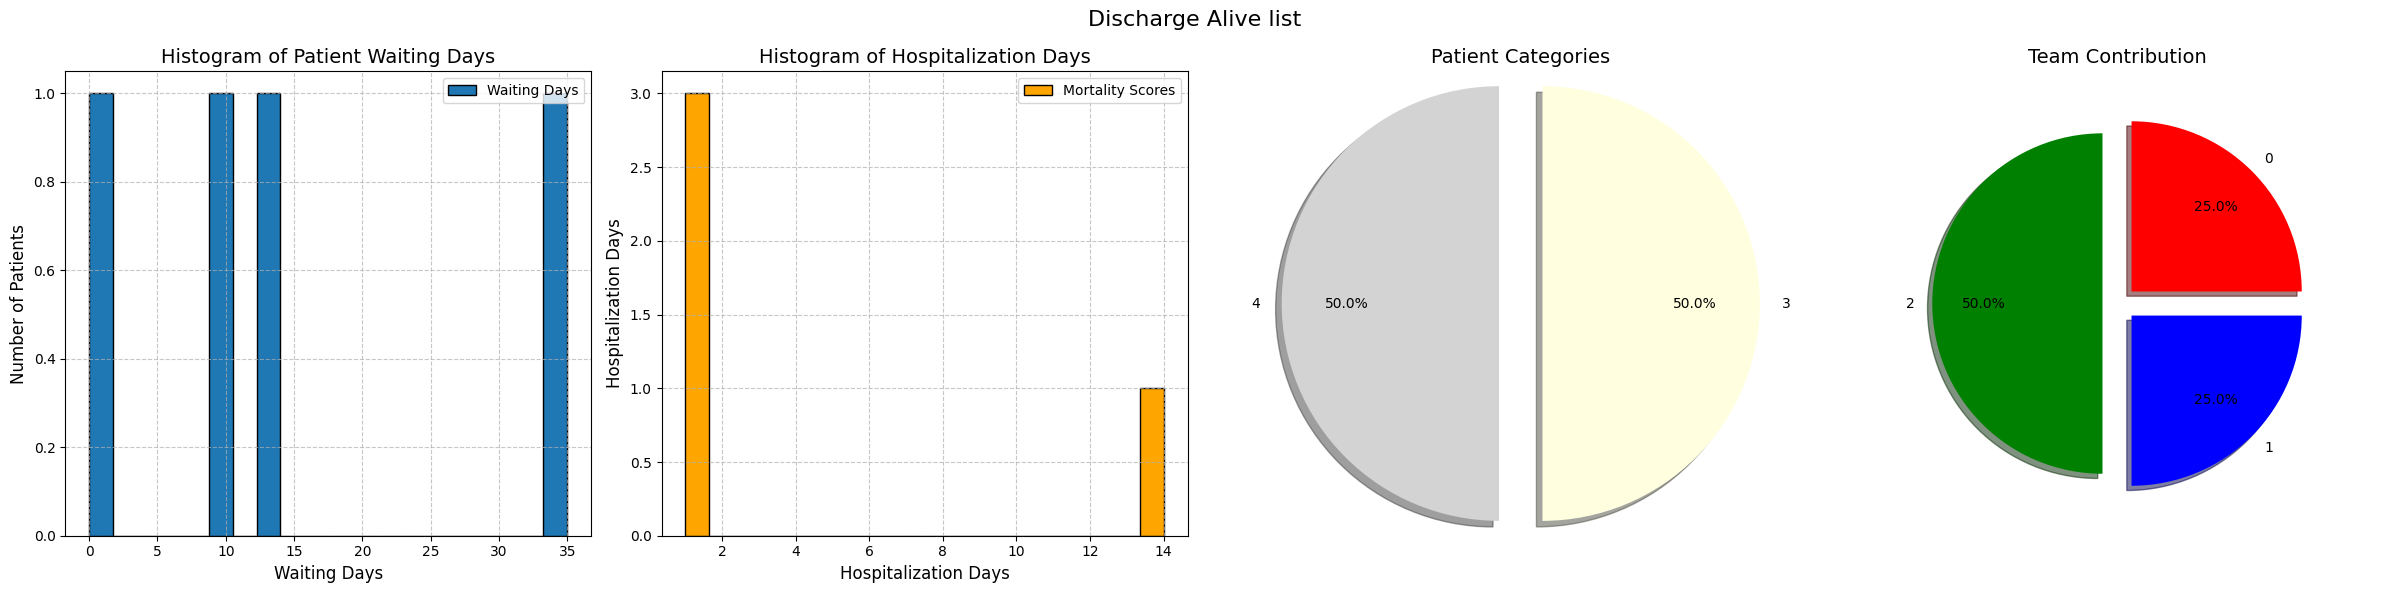

In [21]:
import matplotlib.pyplot as plt

waiting_days = [patient.waiting_day for team, patient in discharge_dead_list]
hospitalization_days = [patient.hospitalization_day for team, patient in discharge_dead_list]
patient_categories = [patient.category for team, patient in discharge_dead_list]
teams = [team for team, patient in discharge_dead_list]

category_counts = {}
for category in patient_categories:
    category_counts[category] = category_counts.get(category, 0) + 1

team_counts = {}
for team in teams:
    team_counts[team] = team_counts.get(team, 0) + 1

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

axes[0].hist(waiting_days, bins=20, edgecolor='black', label='Waiting Days')
axes[0].set_xlabel('Waiting Days', fontsize=12)
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_title('Histogram of Patient Waiting Days', fontsize=14)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend()

# Histogram of Mortality Scores
axes[1].hist(hospitalization_days, bins=20, edgecolor='black', color='orange', label='Mortality Scores')
axes[1].set_xlabel('Hospitalization Days', fontsize=12)
axes[1].set_ylabel('Hospitalization Days', fontsize=12)
axes[1].set_title('Histogram of Hospitalization Days', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend()

# Pie chart of Patient Categories
labels = list(category_counts.keys())
sizes = list(category_counts.values())
explode = [0.1] * len(labels)
category_colors = {0: 'lightcoral', 1: 'lightblue', 2: 'lightgreen', 3: 'lightyellow', 4: 'lightgrey'}
colors = [category_colors[label] for label in labels]
axes[2].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, pctdistance=0.7)
axes[2].axis('equal')
axes[2].set_title('Patient Categories', fontsize=14)

# Pie chart of Patient Categories
labels = list(team_counts.keys())
sizes = list(team_counts.values())
explode = [0.1] * len(labels)
team_colors = {0: 'red', 1: 'blue', 2: 'green'}
colors = [team_colors[label] for label in labels]
axes[3].pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, pctdistance=0.7)
axes[3].axis('equal')
axes[3].set_title('Team Contribution', fontsize=14)

fig.suptitle('Discharge Dead list', fontsize=16)
plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show()

# Educational score

In [31]:
Edu_score = np.exp(-np.sum(hospital.team_category))
print(Edu_score)
print(hospital.team_category)

2.3195228302435696e-16
[[ 0.  0.  7.  3.  0.]
 [ 0.  0.  0. 26.  0.]
 [ 0.  0.  0.  0.  0.]]


array([[ 0.,  0.,  7.,  3.,  0.],
       [ 0.,  0.,  0., 26.,  0.],
       [ 0.,  0.,  0.,  0.,  0.]])